<a href="https://colab.research.google.com/github/ThisarikaTNA/sentiment_analysis-CM3604/blob/main/LSTM_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import necessary Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.optimizers import Adam

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
review_datasetpath = '/content/drive/MyDrive/yelp_dataset/yelp_academic_dataset_review.json'


Load ans Print sample review dataset data

In [ ]:
# Load review data
review_df = pd.read_json(review_datasetpath, lines=True, nrows=1000000)

print("Review DataFrame Info:")
print(review_df.info())

print("Sample of Review DataFrame:")
print(review_df.head())



Review DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   review_id    1000000 non-null  object        
 1   user_id      1000000 non-null  object        
 2   business_id  1000000 non-null  object        
 3   stars        1000000 non-null  int64         
 4   useful       1000000 non-null  int64         
 5   funny        1000000 non-null  int64         
 6   cool         1000000 non-null  int64         
 7   text         1000000 non-null  object        
 8   date         1000000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 68.7+ MB
None
Sample of Review DataFrame:
                review_id                 user_id             business_id  \
0  KU_O5udG6zpxOg-VcAEodg  mh_-eMZ6K5RLWhZyISBhwA  XQfwVwDr-v0ZS3_CbbE5Xw   
1  BiTunyQ73aT9WBnpR9DZGw  OyoGAe7OKpv6SyGZT5g77

In [ ]:
# Create a new column "length" with the word length of the review
review_df['length'] = review_df['text'].apply(lambda x: len(x.split()))

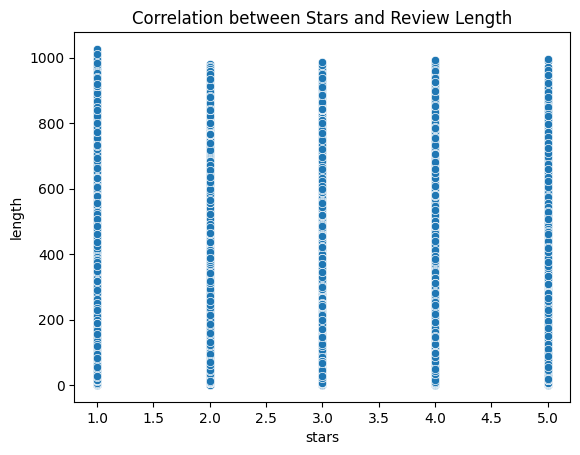

In [ ]:
# Visualize the correlation between stars and the length of the review
sns.scatterplot(x='stars', y='length', data=review_df)
plt.title('Correlation between Stars and Review Length')
plt.show()


In [ ]:
# getting mean value of the vote columns
mean_votes = review_df[['useful', 'funny', 'cool']].mean()
print('Mean Value of the Vote columns:')
print(mean_votes)


Mean Value of the Vote columns:
useful    1.106594
funny     0.307812
cool      0.457129
dtype: float64


In [ ]:
# Correlation between the voting columns
correlation_matrix = review_df[['useful', 'funny', 'cool']].corr()
print('\nCorrelation between the voting columns:')
print(correlation_matrix)


Correlation between the voting columns:
          useful     funny      cool
useful  1.000000  0.575495  0.690023
funny   0.575495  1.000000  0.708279
cool    0.690023  0.708279  1.000000


Preprocess the Dataset

In [ ]:
def preprocess_text(text):
    text = text.lower()
    text = ' '.join([word for word in text.split() if word not in ENGLISH_STOP_WORDS])
    text = ''.join([char for char in text if char.isalnum() or char.isspace()])
    return text


# Apply text preprocessing to the 'text' column in the review DataFrame
review_df['text'] = review_df['text'].apply(preprocess_text)

# Handle missing values if any
review_df.dropna(inplace=True)

# Remove duplicate rows based on the 'text' column
review_df.drop_duplicates(subset=['text'], inplace=True)

# Assuming sentiment is positive for stars greater than or equal to 4, and negative otherwise
review_df['label'] = (review_df['stars'] >= 4).astype(int)

# Display the preprocessed DataFrame
print("\nSample of Preprocessed Review DataFrame:")
print(review_df.head())



Sample of Preprocessed Review DataFrame:
                review_id                 user_id             business_id  \
0  KU_O5udG6zpxOg-VcAEodg  mh_-eMZ6K5RLWhZyISBhwA  XQfwVwDr-v0ZS3_CbbE5Xw   
1  BiTunyQ73aT9WBnpR9DZGw  OyoGAe7OKpv6SyGZT5g77Q  7ATYjTIgM3jUlt4UM3IypQ   
2  saUsX_uimxRlCVr67Z4Jig  8g_iMtfSiwikVnbP2etR0A  YjUWPpI6HXG530lwP-fb2A   
3  AqPFMleE6RsU23_auESxiA  _7bHUi9Uuf5__HHc_Q8guQ  kxX2SOes4o-D3ZQBkiMRfA   
4  Sx8TMOWLNuJBWer-0pcmoA  bcjbaE6dDog4jkNY91ncLQ  e4Vwtrqf-wpJfwesgvdgxQ   

   stars  useful  funny  cool  \
0      3       0      0     0   
1      5       1      0     1   
2      3       0      0     0   
3      5       1      0     1   
4      4       1      0     1   

                                                text                date  \
0  decide eat here just aware going 2 hours begin... 2018-07-07 22:09:11   
1  ive taken lot spin classes years compares clas... 2012-01-03 15:28:18   
2  family diner buffet eclectic assortment large ... 2014-02-05 20:3

In [ ]:
# Save the preprocessed review DataFrame to a CSV file
preprocessed_csv_path = '/content/drive/MyDrive/yelp_dataset/preprocessed_reviews.csv'
review_df.to_csv(preprocessed_csv_path, index=False)
print(f"Preprocessed dataset saved to {preprocessed_csv_path}")



Preprocessed dataset saved to /content/drive/MyDrive/yelp_dataset/preprocessed_reviews.csv


Split the dataset into training (80%) and test (20%) sets

In [ ]:
train_data, test_data = train_test_split(review_df, test_size=0.2, random_state=42)

In [ ]:
# Load  preprocessed Yelp Reviews dataset
data = pd.read_csv('/content/drive/MyDrive/yelp_dataset/preprocessed_reviews.csv')

# getting data to list from the lable column for sentiment (0 or 1)
labels = data['label'].tolist()



Model 1: LSTM

In [ ]:
max_len = 128
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(train_data['text'])

train_sequences = tokenizer.texts_to_sequences(train_data['text'])
test_sequences = tokenizer.texts_to_sequences(test_data['text'])

train_padded = pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')


In [ ]:
lstm_model = Sequential()
lstm_model.add(Embedding(len(tokenizer.word_index) + 1, 128, input_length=max_len))
lstm_model.add(Bidirectional(LSTM(64)))
lstm_model.add(Dense(1, activation='sigmoid'))

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.fit(train_padded, train_data['label'], epochs=10, batch_size=32, validation_data=(test_padded, test_data['label']))

Epoch 1/10
24951/24951 [==============================] - 698s 28ms/step - loss: 0.2254 - accuracy: 0.9087 - val_loss: 0.2013 - val_accuracy: 0.9191
Epoch 2/10
24951/24951 [==============================] - 618s 25ms/step - loss: 0.1741 - accuracy: 0.9311 - val_loss: 0.1958 - val_accuracy: 0.9212
Epoch 3/10
24951/24951 [==============================] - 624s 25ms/step - loss: 0.1341 - accuracy: 0.9487 - val_loss: 0.2196 - val_accuracy: 0.9153
Epoch 4/10
24951/24951 [==============================] - 617s 25ms/step - loss: 0.0980 - accuracy: 0.9637 - val_loss: 0.2474 - val_accuracy: 0.9097
Epoch 5/10
24951/24951 [==============================] - 614s 25ms/step - loss: 0.0723 - accuracy: 0.9736 - val_loss: 0.3128 - val_accuracy: 0.9037
Epoch 6/10
24951/24951 [==============================] - 611s 24ms/step - loss: 0.0543 - accuracy: 0.9804 - val_loss: 0.3545 - val_accuracy: 0.8964
Epoch 7/10
24951/24951 [==============================] - 618s 25ms/step - loss: 0.0418 - accuracy: 0.9851

Evaluate and Calculate metrics for LSTM model

In [ ]:
lstm_predictions = lstm_model.predict(test_padded)
lstm_predictions = np.round(lstm_predictions).flatten()
lstm_accuracy = accuracy_score(test_data['label'], lstm_predictions)
print(f'LSTM Model Accuracy: {lstm_accuracy * 100:.2f}%')

6238/6238 [==============================] - 34s 5ms/step
LSTM Model Accuracy: 88.96%


In [ ]:
lstm_precision = precision_score(test_data['label'], lstm_predictions)
lstm_recall = recall_score(test_data['label'], lstm_predictions)
lstm_f1 = f1_score(test_data['label'], lstm_predictions)
lstm_conf_matrix = confusion_matrix(test_data['label'], lstm_predictions)

print(f'LSTM Model Precision: {lstm_precision:.2f}')
print(f'LSTM Model Recall: {lstm_recall:.2f}')
print(f'LSTM Model F1 Score: {lstm_f1:.2f}')
print('LSTM Model Confusion Matrix:')
print(lstm_conf_matrix)


LSTM Model Precision: 0.92
LSTM Model Recall: 0.91
LSTM Model F1 Score: 0.92
LSTM Model Confusion Matrix:
[[ 53803  10082]
 [ 11951 123770]]
